In [1]:
import numpy as np
import matplotlib.pyplot as plt


# Modulation et démodulation DSB-SC

## Modulation

In [17]:
a = -7 
b = 7

f_max = 5/(4*b) # fréquence maximale du signal à transmettre
print("fréquence maximale du signal à transmettre : ", np.round(f_max,2), "Hz")

def x_inf(t):
    return np.cos(5*np.pi/2*t/b) + np.sin(np.pi*t/b) # la période minimale est donc 4b/5

def ind(t,a=a,b=b): # indicatrice entre a et b
    if t < a or t > b:
        return 0
    else :
        return 1
    
def x(t):
    return x_inf(t)*ind(t)

fréquence maximale du signal à transmettre :  0.18 Hz


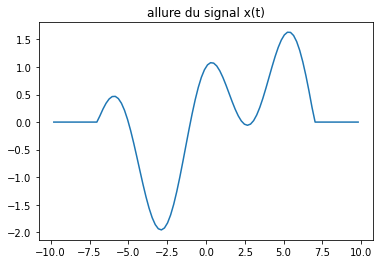

In [55]:
e = (b-a)/5
def afficher_signal(f,titre, m=a-e, M=b+e): #titre est une chaine de caractère
    Lt = np.linspace(m,M,100) # Les signaux auront toujours un domaine de définition centré en 0
    plt.figure()
    plt.plot(Lt,np.vectorize(f)(Lt))
    plt.title(titre)

afficher_signal(x,"allure du signal x(t)")

Le signal est à bande limitée, donc non périodique.
<br/> On calcule va interpoler le signal et calculer sa TFD.

fréquence d'échantilionnage : 17.86 kHz


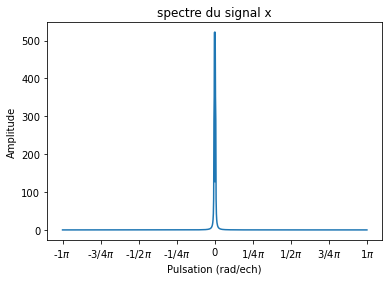

In [46]:
N = 10**3

fc = 1000*f_max # pour avoir fc >> f_max (par ex en radio FM, on a fc environ 100MHz pour un B d'environ 15kHZ)
f_inf = 100*fc
print("fréquence d'échantilionnage :", np.round(f_inf/10**3,2), "kHz")

def x_discret(x,N): # a,b connus
    return np.vectorize(x)(np.linspace(a,b,N))

x_interpolé = x_discret(x,N)

from fractions import Fraction

def afficher_spectre(x_discret, titre): # x est discret 
    N = len(x_discret)
    plt.figure()
    # on veut afficher entre -pi et pi au lieu de 0 et 2pi
    X_normé_discret = np.abs(np.fft.fft(x_discret))
    res = np.zeros((N)) 
    res[:N//2] = X_normé_discret[N//2:]
    res[N//2:] = X_normé_discret[:N//2]
    plt.plot(np.linspace(-np.pi,np.pi,N),res)
    plt.title(titre)
    plt.ylabel('Amplitude')
    plt.xlabel('Pulsation (rad/ech)')
    plt.xticks(np.linspace(-np.pi,np.pi,9),[str(-Fraction(k*2/8))+'$\pi$' for k in range(1,5)][::-1]+[0]+[str(Fraction(k*2/8))+'$\pi$' for k in range(1,5)])
    plt.show()

afficher_spectre(x_interpolé, "spectre du signal x")

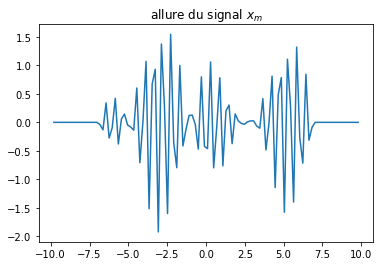

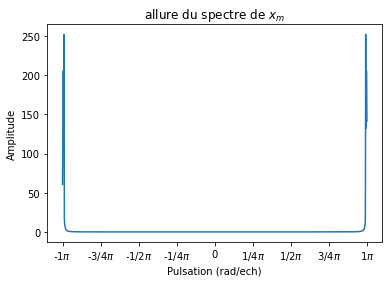

In [89]:
def xm(t):
    return x(t)*np.cos(2*np.pi*fc*t)

afficher_signal(xm, "allure du signal $x_m$")

xm_discret = x_discret(xm,N)
afficher_spectre(xm_discret,"allure du spectre de $x_m$")

Comme son som l'indique (Double-SideBand Supressed-Carrier), la modulation donne un spectre à une bande de chaque côté et rien au milieu.

## Démodulation synchrone "analogique"

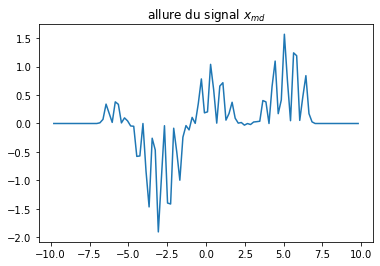

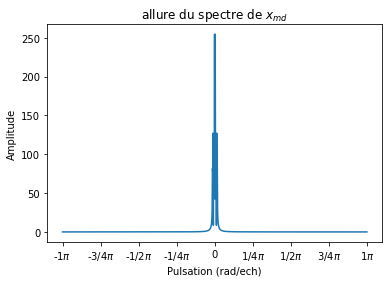

In [42]:
def xmd(t):
    return xm(t)*np.cos(2*np.pi*fc*t)

afficher_signal(xmd, "allure du signal $x_{md}$");


xmd_discret = x_discret(xmd,N)
afficher_spectre(xmd_discret,"allure du spectre de $x_{md}$")


On va filtrer $x_{md}$ par un passe-bas : Gardons uniquement le 1er pic du spectre (ou plus généralement les pulsations entre 0 et 0,2 rad/ech, ie en gros les 20 premières ; on met le reste à 0.

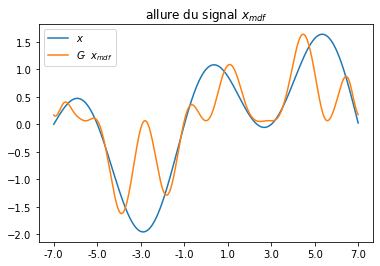

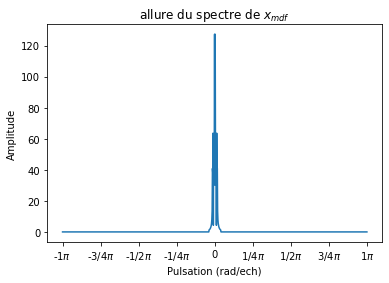

In [94]:
Xmd_discret = np.fft.fft(xmd_discret)
Xmdf_discret = Xmd_discret.copy()
deb = 20 # à partir de 20 on met tout à 0
Xmdf_discret[deb:] = 0



xmdf = np.real(np.fft.ifft(Xmdf_discret)) # on ne prend que la partie réelle

y = (max(xmdf)+min(xmdf))/2


G = max(x_interpolé)/max(xmdf) # facteur d'atténuation de l'amplitude


plt.figure() 
Lt = np.arange(N)
plt.plot(Lt,np.vectorize(x)((Lt-N/2)*b/500),label="$x$")
plt.plot(xmdf*G, label="$G \dot \ x_{mdf}$")

# on recadre entre -7 et 7 au lieu d'avoir la suite entre 0 et 1000
plt.xticks(np.linspace(0,N,8),np.vectorize(str)(np.linspace(-7,7,8))) 
plt.legend()
plt.title("allure du signal $x_{mdf}$")
plt.show()


afficher_spectre(xmdf, "allure du spectre de $x_{mdf}$")

In [99]:
print("Après filtrage pas un passe bas, on ne retrouve pas exactement le signal d'origine.")
print("L'amplitude a été divisée d'un facteur", np.round(G,2))
print("Les deux signaux gardent toutefois la même allure.")

Après filtrage pas un passe bas, on ne retrouve pas exactement le signal d'origine.
L'amplitude a été divisée d'un facteur 4.01
Les deux signaux gardent toutefois la même allure.


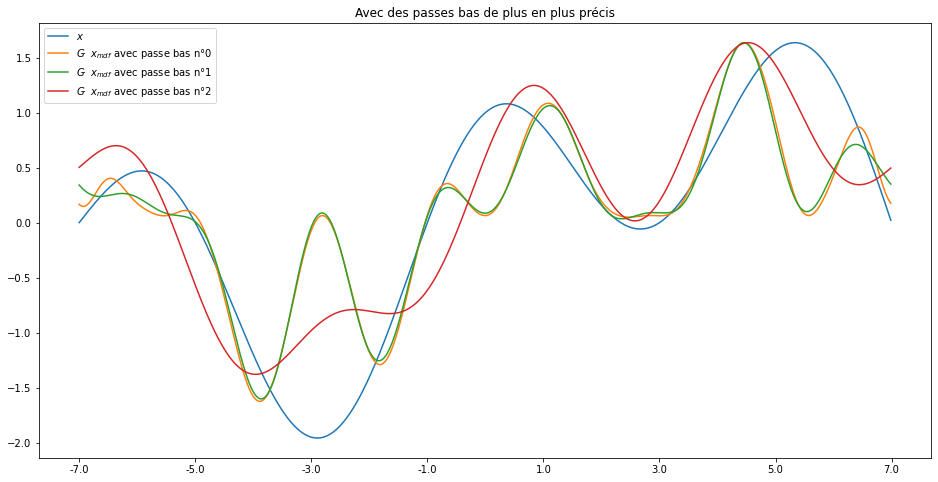

In [106]:
deb = [20,10,5] # à partir de 20 on met tout à 0

plt.figure(figsize=(16,8)) 
Lt = np.arange(N)
plt.plot(Lt,np.vectorize(x)((Lt-N/2)*b/500),label="$x$")

for i in range(len(deb)) :
    
    Xmdf_discret = Xmd_discret.copy()
    Xmdf_discret[deb[i]:] = 0
    xmdf = np.real(np.fft.ifft(Xmdf_discret)) # on ne prend que la partie réelle
    y = (max(xmdf)+min(xmdf))/2
    G = max(x_interpolé)/max(xmdf) # facteur d'atténuation de l'amplitude

    plt.plot(xmdf*G, label="$G \dot \ x_{mdf}$ avec passe bas n°" +str(i))

# on recadre entre -7 et 7 au lieu d'avoir la suite entre 0 et 1000
plt.xticks(np.linspace(0,N,8),np.vectorize(str)(np.linspace(-7,7,8))) 
plt.legend()
plt.title("Avec des passes bas de plus en plus précis")
plt.show()



Le théorème de Shannon assure que l'on doit avoir $f_e \geq 2f_{max}$
<br/> Le fréquence minimale d'échantillonage possible est donc $f_{e,min} = 2f_{max}$

In [111]:
f_e = 2*f_max
print("La fréquence minimale d'échantillonage de x est de ",np.round(f_e,2), 'Hz')

print("B =", np.round(f_max,2), "Hz")
print("f_c = ", np.round(fc,2), "Hz")
print("f_inf = ", np.round(f_inf,2), "Hz")

La fréquence minimale d'échantillonage de x est de  0.36 Hz
B = 0.18 Hz
f_c =  178.57 Hz
f_inf =  17857.14 Hz


In [110]:
# Pour x_m, on a clairement la pulsation maximale :
wm = np.pi #(en rad/échantillon)

# d'où
fm = wm/(2*np.pi)*N

print("Ainsi la fréquence minimale d'échantillonage pour x_m serait de ", 2*fm, "Hz")

Ainsi la fréquence minimale d'échantillonage pour x_m serait de  1000.0 Hz


**Bilan :** On ne peut pas échantilloner $x_m$ à 0.36 Hz (sinon on perd de l'information : c'est le repliement)

## Démodulation synchrone par sous échantillonage

In [12]:
n = 10
fs = fm/n

#On échantillonne x_m à la fréquence d'échantillonage fs
#Soit M le nombre d'échantillons. On a (2M+1)delta t = 14 
M = int((14*fs-1)/2)
xm_discret_fs = np.vectorize(xm)(np.linspace(-7,7,M))

plt.plot(xm_discret_fs)
#afficher_signal(xm_discret_fs, "allure du signal $x_m$ échantilloné avec n =" + str(n))


ValueError: cannot call `vectorize` on size 0 inputs unless `otypes` is set

C'est normal que ce ne soit pas possible car on a alors fs = 0.1 Hz (soit un pas d'échantillonage de 10)

La fréquence minimale d'échantillonage est de 1.9 Hz

En raisonnant ainsi on va laisser tomber les fréquences hautes

# À faire :
* Généraliser les fonctions à des spectres quelconques
* Mettre dans les spectres les pas en multiples de pi